# Bert FineTuning

In [1]:
import pandas as pd
import numpy as np
import requests
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

* download model

In [2]:
model_name = "HooshvareLab/bert-base-parsbert-uncased"
num_classes = 3

config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name, num_labels=num_classes)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
!pip install hazm

import hazm

  Using cached hazm-0.9.4-py3-none-any.whl (371 kB)
  Using cached fasttext_wheel-0.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.4 MB)
  Using cached flashtext-2.7.tar.gz (14 kB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 24.4 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=0bd254ae647e8182000a9d35e31da5273727bee504b2974269fbb3ead43c3745
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take

In [ ]:
text = "مـا معـتـقـدیـم بـا انتقـال  صحیح دانش و آگـاهی، همّه افراد می توانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
print("Raw text:\n",text)
# Normalize text
normalizer = hazm.Normalizer()
normalized_text = normalizer.normalize(text)
print("Normalized text:\n",normalized_text)
# Filter stopwords
non_stop_text = ' '.join(word for word in normalized_text.split() if word not in hazm.stopwords_list())
print("Filter stopwords:\n",non_stop_text)

print('\nRaw txt tokens num:',len(tokenizer.tokenize(text)))
print('Normalized txt tokens num:',len(tokenizer.tokenize(normalized_text)))
print('Filtered tokens num:',len(tokenizer.tokenize(non_stop_text)))

Raw text:
 مـا معـتـقـدیـم بـا انتقـال  صحیح دانش و آگـاهی، همّه افراد می توانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است.
Normalized text:
 ما معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد می‌توانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است.
Filter stopwords:
 معتقدیم انتقال صحیح دانش آگاهی، ابزارهای هوشمند استفاده کنند. شعار هوش مصنوعی است.

Raw txt tokens num: 27
Normalized txt tokens num: 26
Filtered tokens num: 16


In [5]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

* download dataset

In [6]:
# !pip install gdown

import gdown
import zipfile
import os

github_url = "https://github.com/dml-qom/FarsTail/archive/refs/heads/master.zip"
zip_file_path = "code.zip"

gdown.download(github_url, zip_file_path, quiet=False)

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()
    os.remove(zip_file_path)

Downloading...
From: https://github.com/dml-qom/FarsTail/archive/refs/heads/master.zip
To: /content/code.zip
1.61MB [00:00, 3.85MB/s]


In [7]:
os.chdir('/content/FarsTail-master/data')
train_data = pd.read_csv('Train-word.csv', sep='\t')
val_data = pd.read_csv('Val-word.csv', sep='\t')
test_data = pd.read_csv('Test-word.csv', sep='\t')
df = pd.concat([train_data, val_data, test_data], axis=0)
os.chdir('/content')

## Q2.1: preprocess dataset

In [ ]:
print('Train data:',end='\t')
print(train_data.info())
print('\nValid data:',end='\t')
print(val_data.info())
print('\nTest data:',end='\t')
print(test_data.info())

Train data:	<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7266 entries, 0 to 7265
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     7266 non-null   object
 1   hypothesis  7266 non-null   object
 2   label       7266 non-null   object
dtypes: object(3)
memory usage: 170.4+ KB
None

Valid data:	<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     1537 non-null   object
 1   hypothesis  1537 non-null   object
 2   label       1537 non-null   object
dtypes: object(3)
memory usage: 36.1+ KB
None

Test data:	<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   premise           1564 non-null   object
 1   hypothesi

In [ ]:
test_data.head()

,premise,hypothesis,label,hard(hypothesis),hard(overlap)
0,دوران امامت امام صادق علیه السلام، مصادف است ب...,امام سجاد (ع) در دورانی امامت کردند که همزمان ...,c,0,1
1,دوران امامت امام صادق علیه السلام، مصادف است ب...,دستگاه فاسد حکومتی با صرف هزینه های هنگفت، سعی...,n,1,0
2,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,دوران محنت اهل بیت پس از شهادت امام رضا(ع) آغا...,e,0,0
3,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,بعد از به شهادت رسیدن امام هادی(ع) دوران محنت ...,c,1,1
4,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,حضرت جواد(ع) در سال ۱۹۵ هجری در مدینه ولادت یافت.,n,1,0


* Class Distribution:

Class Distribution:
n    3506
e    3463
c    3398
Name: label, dtype: int64


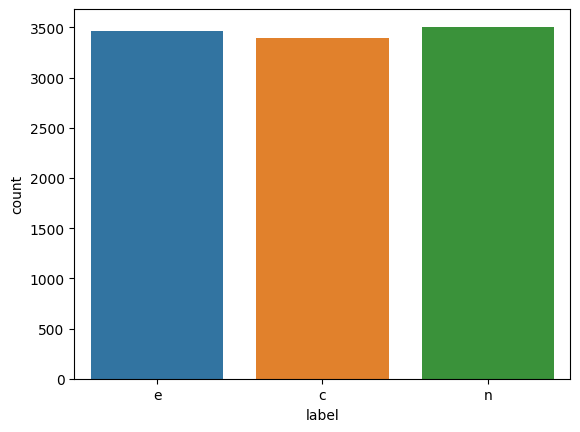

In [ ]:
class_distribution = df['label'].value_counts()
print("Class Distribution:")
print(class_distribution)

sns.countplot(data=df, x='label')
plt.show()

* Encode labels

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

print('Labels:',df['label'].unique())
train_data['label'] = le.fit_transform(train_data['label'])
val_data['label'] = le.fit_transform(val_data['label'])
test_data['label'] = le.fit_transform(test_data['label'])
print('Encoded labels:',train_data['label'].unique())

Labels: ['e' 'c' 'n']
Encoded labels: [1 0 2]


* Normalize dataset

In [9]:
normalizer = hazm.Normalizer()

train_data['premise'] = train_data['premise'].apply(lambda x: normalizer.normalize(x))
train_data['hypothesis'] = train_data['hypothesis'].apply(lambda x: normalizer.normalize(x))
val_data['premise'] = val_data['premise'].apply(lambda x: normalizer.normalize(x))
val_data['hypothesis'] = val_data['hypothesis'].apply(lambda x: normalizer.normalize(x))
test_data['premise'] = test_data['premise'].apply(lambda x: normalizer.normalize(x))
test_data['hypothesis'] = test_data['hypothesis'].apply(lambda x: normalizer.normalize(x))

df = pd.concat([train_data, val_data, test_data], axis=0)

* Distribution of Sentence Lengths

In [ ]:
premise_lengths = df['premise'].apply(lambda x: len(tokenizer.tokenize(x)))
hypothesis_lengths = df['hypothesis'].apply(lambda x: len(tokenizer.tokenize(x)))

combined_lengths = premise_lengths + hypothesis_lengths

print("Sentence Lengths (in tokens):")
print("Mean:", combined_lengths.mean())
print("Median:", combined_lengths.median())
print("Maximum:", combined_lengths.max())
print("Minimum:", combined_lengths.min())

Sentence Lengths (in tokens):
Mean: 56.254750651104466
Median: 54.0
Maximum: 150
Minimum: 13


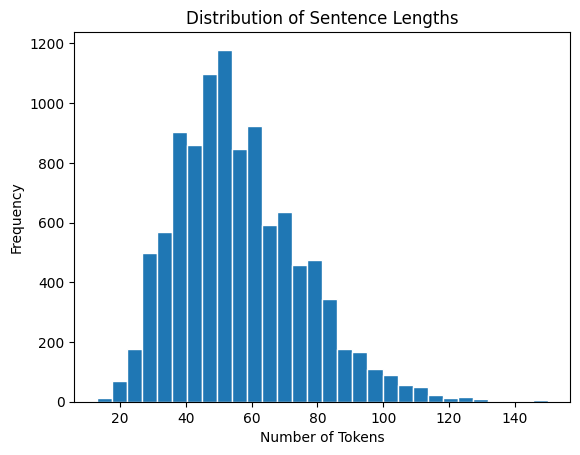

In [ ]:
plt.hist(combined_lengths, bins=30, edgecolor='white')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

## Q2.2: fine-tuning all layers

In [10]:
# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


* Define fine-tuning dataset class

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=160):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        premise = str(self.data.iloc[idx]['premise'])
        hypothesis = str(self.data.iloc[idx]['hypothesis'])
        label = int(self.data.iloc[idx]['label'])

        encoding = self.tokenizer(
            premise,
            hypothesis,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

* Define training parameters

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data))
criterion = nn.CrossEntropyLoss()

* Create DataLoader instances for train, validation, and test sets

In [12]:
train_dataset = CustomDataset(train_data, tokenizer)
val_dataset = CustomDataset(val_data, tokenizer)
test_dataset = CustomDataset(test_data, tokenizer)

batch_size=32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

* Training loop

In [13]:
def fine_tune_and_validation_model(model,num_epochs = 3):
    train_loss_list = []
    val_loss_list = []
    accuracy_list = []

    # Train
    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_losses.append(loss.item())

        train_loss = sum(train_losses) / len(train_losses)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        val_losses = []
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                val_losses.append(loss.item())
                val_predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = sum(val_losses) / len(val_losses)
        val_loss_list.append(val_loss)

        # Evaluation metrics on validation set
        accuracy = accuracy_score(val_labels, val_predictions)
        accuracy_list.append(accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs} - '
            f'Train Loss: {train_loss:.4f} - '
            f'Validation Loss: {val_loss:.4f} - '
            f'Accuracy: {accuracy:.4f}')

    return train_loss_list, val_loss_list, accuracy_list

In [ ]:
train_loss_list, val_loss_list, accuracy_list = fine_tune_and_validation_model(model,num_epochs = 5)

In [ ]:
torch.save(model.state_dict(), 'fine_tuned_model.pth')

* Test set evaluation

In [25]:
def test_set_evaluation(model):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            test_predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Evaluation metrics on the test set
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_f1 = f1_score(test_labels, test_predictions, average='weighted')
    conf_matrix = confusion_matrix(test_labels, test_predictions)

    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

In [ ]:
test_set_evaluation(model)

Test Accuracy: 0.8229
Test F1 Score: 0.8217
Confusion Matrix:
[[366  88  56]
 [ 66 441  12]
 [ 43  12 480]]


* Plotting the training and validation curves

In [14]:
def plot_loss_accuracy_changes(train_loss_list, val_loss_list, accuracy_list):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, '-o', label='Train Loss')
    plt.plot(val_loss_list, '-^', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list,'-s', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

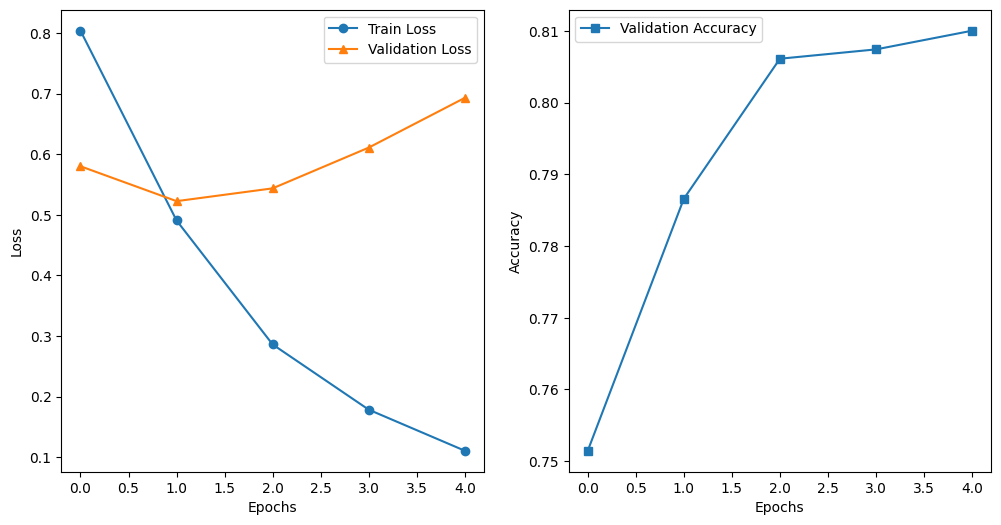

In [ ]:
plot_loss_accuracy_changes(train_loss_list, val_loss_list, accuracy_list)

## Q2.3:

In [16]:
# Free GPU RAM
model.to('cpu');
del model
torch.cuda.empty_cache()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device);

* freeze the embeddings and the weights of the first 9 layers

In [ ]:
for param in model.base_model.embeddings.parameters():
    param.requires_grad = False

for i in range(9):
    for name, param in model.base_model.encoder.layer[i].named_parameters():
        param.requires_grad = False

params = [param for param in model.parameters() if param.requires_grad]
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data))

In [ ]:
train_loss_list, val_loss_list, accuracy_list = fine_tune_and_validation_model(model,num_epochs = 5)

Epoch 1/5 - Train Loss: 0.9312 - Validation Loss: 0.7258 - Accuracy: 0.6688
Epoch 2/5 - Train Loss: 0.7308 - Validation Loss: 0.6398 - Accuracy: 0.7072
Epoch 3/5 - Train Loss: 0.6237 - Validation Loss: 0.5968 - Accuracy: 0.7319
Epoch 4/5 - Train Loss: 0.5474 - Validation Loss: 0.5627 - Accuracy: 0.7450
Epoch 5/5 - Train Loss: 0.4700 - Validation Loss: 0.5621 - Accuracy: 0.7541


In [ ]:
test_set_evaluation(model)

Test Accuracy: 0.7864
Test F1 Score: 0.7835
Confusion Matrix:
[[320 138  52]
 [ 44 453  22]
 [ 42  36 457]]


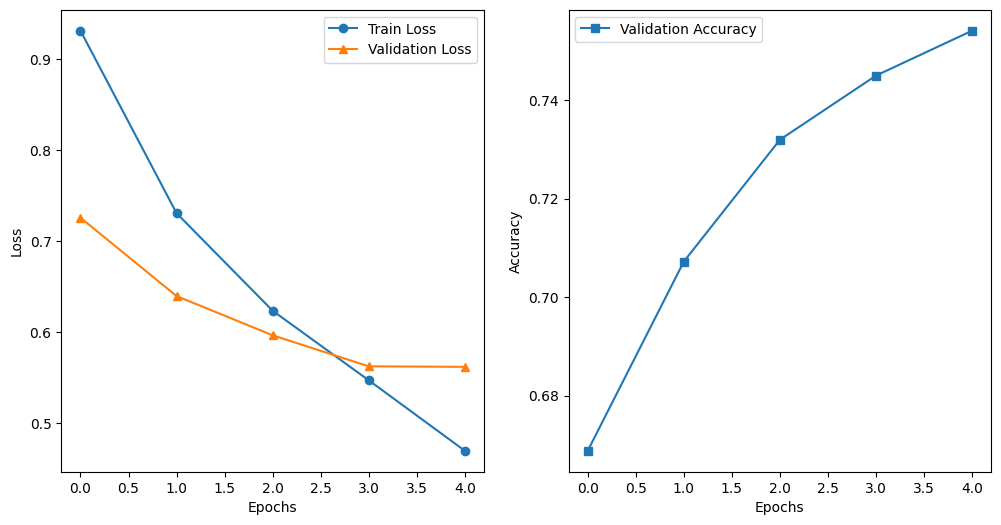

In [ ]:
plot_loss_accuracy_changes(train_loss_list, val_loss_list, accuracy_list)

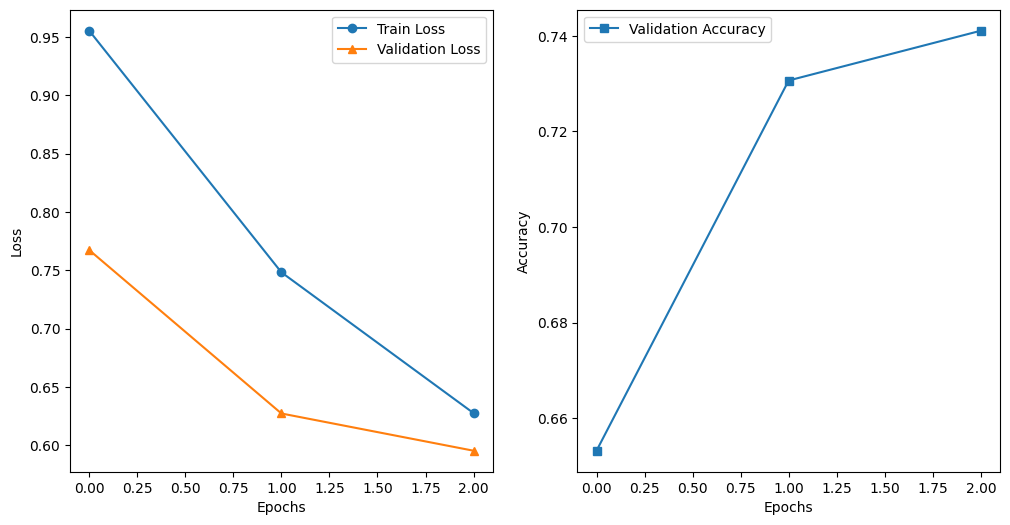

In [ ]:
# fine-tune model without normalization dataset
plot_loss_accuracy_changes(train_loss_list, val_loss_list, accuracy_list)

* freeze all layers except output layer

In [20]:
model.to('cpu');
del model
torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device);

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

params = [param for param in model.parameters() if param.requires_grad]
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data))
criterion = nn.CrossEntropyLoss()

In [22]:
train_loss_list, val_loss_list, accuracy_list = fine_tune_and_validation_model(model,num_epochs = 5)

Epoch 1/5 - Train Loss: 1.0974 - Validation Loss: 1.0890 - Accuracy: 0.3748
Epoch 2/5 - Train Loss: 1.0896 - Validation Loss: 1.0821 - Accuracy: 0.4047
Epoch 3/5 - Train Loss: 1.0812 - Validation Loss: 1.0764 - Accuracy: 0.4242
Epoch 4/5 - Train Loss: 1.0794 - Validation Loss: 1.0721 - Accuracy: 0.4320
Epoch 5/5 - Train Loss: 1.0748 - Validation Loss: 1.0692 - Accuracy: 0.4314


In [26]:
test_set_evaluation(model)

Test Accuracy: 0.4322
Test F1 Score: 0.4233
Confusion Matrix:
[[153 227 130]
 [119 322  78]
 [142 192 201]]


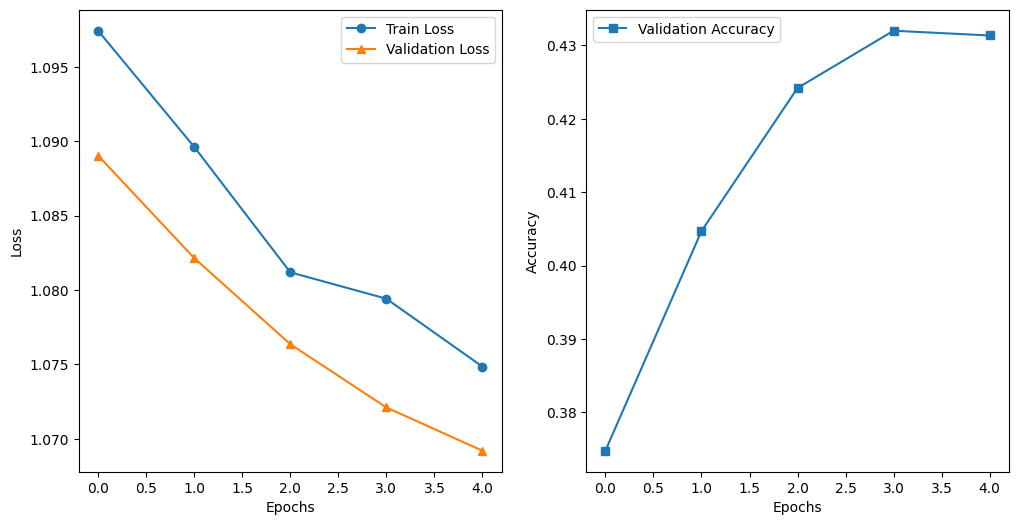

In [24]:
plot_loss_accuracy_changes(train_loss_list, val_loss_list, accuracy_list)

## Q2.4:

In [27]:
class CustomBertModel(nn.Module):
    def __init__(self, num_labels=2):
        super(CustomBertModel, self).__init__()
        # Load the pre-trained BERT model
        self.bert = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=num_labels)
        # Retain the first 9 layers
        self.bert.bert.encoder.layer = self.bert.bert.encoder.layer[:9]
        # Retain the classifier layer
        self.classifier = self.bert.classifier

    def forward(self, input_ids, attention_mask=None, labels=None):
        return self.bert(input_ids, attention_mask=attention_mask, labels=labels)

In [ ]:
custom_model = CustomBertModel(num_labels=num_classes)
custom_model.to(device)

optimizer = AdamW(custom_model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data))


In [29]:
train_loss_list, val_loss_list, accuracy_list = fine_tune_and_validation_model(custom_model,num_epochs = 5)

Epoch 1/5 - Train Loss: 0.8089 - Validation Loss: 0.6120 - Accuracy: 0.7372
Epoch 2/5 - Train Loss: 0.4908 - Validation Loss: 0.5438 - Accuracy: 0.7788
Epoch 3/5 - Train Loss: 0.3053 - Validation Loss: 0.6033 - Accuracy: 0.7866
Epoch 4/5 - Train Loss: 0.1788 - Validation Loss: 0.6321 - Accuracy: 0.8003
Epoch 5/5 - Train Loss: 0.1094 - Validation Loss: 0.8380 - Accuracy: 0.7775


In [30]:
test_set_evaluation(model)

Test Accuracy: 0.4322
Test F1 Score: 0.4233
Confusion Matrix:
[[153 227 130]
 [119 322  78]
 [142 192 201]]


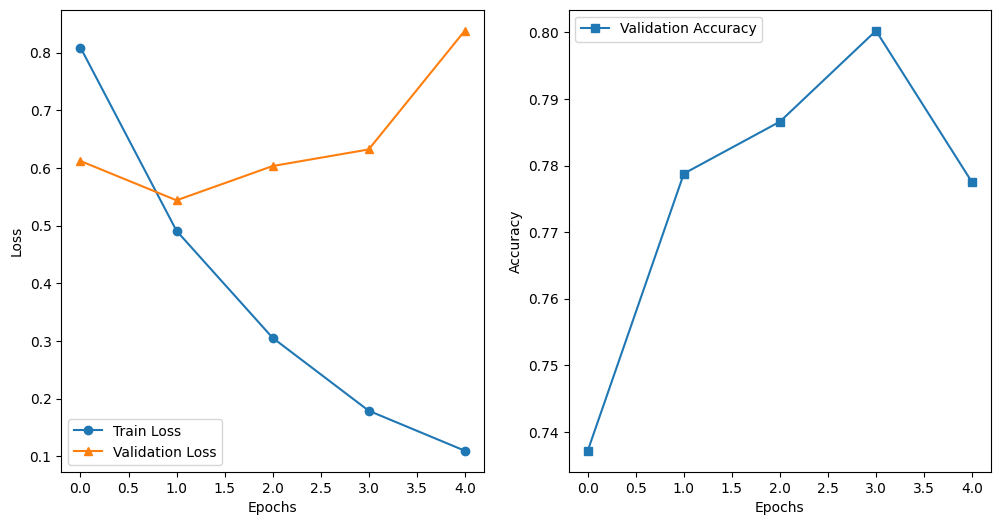

In [31]:
plot_loss_accuracy_changes(train_loss_list, val_loss_list, accuracy_list)

## Q2.5

In [ ]:
print("num attention heads:",model.config.num_attention_heads)
print("num hidden layers:",model.config.num_hidden_layers)
print()

12

In [ ]:
import random

prune_percentage = 0.5

for layer_idx in range(config.num_hidden_layers):
    num_heads = config.num_attention_heads
    num_heads_to_prune = int(num_heads * prune_percentage)
    heads_to_prune = random.sample(range(num_heads), num_heads_to_prune)

    model.bert.encoder.layer[layer_idx].attention.prune_heads(heads_to_prune)
    print(f'[{layer_idx}] num_heads:{num_heads}, prune_heads: {heads_to_prune}')

[0] num_heads:12, prune_heads: [3, 6, 11, 5, 1, 2]
[1] num_heads:12, prune_heads: [5, 4, 10, 9, 3, 1]
[2] num_heads:12, prune_heads: [5, 9, 7, 1, 10, 8]
[3] num_heads:12, prune_heads: [4, 7, 1, 10, 9, 5]
[4] num_heads:12, prune_heads: [11, 1, 10, 5, 3, 7]
[5] num_heads:12, prune_heads: [2, 0, 3, 10, 5, 7]
[6] num_heads:12, prune_heads: [11, 2, 5, 8, 0, 9]
[7] num_heads:12, prune_heads: [3, 6, 0, 11, 5, 4]
[8] num_heads:12, prune_heads: [10, 9, 11, 0, 3, 6]
[9] num_heads:12, prune_heads: [2, 6, 4, 0, 10, 5]
[10] num_heads:12, prune_heads: [3, 6, 2, 8, 0, 9]
[11] num_heads:12, prune_heads: [3, 10, 11, 9, 8, 0]


In [43]:
# Check if heads are pruned in each layer
for layer_idx, layer in enumerate(model.bert.encoder.layer):
        print(f"[{layer_idx}]: num_heads: {layer.attention.self.num_attention_heads}")

[0]: num_heads: 6
[1]: num_heads: 6
[2]: num_heads: 6
[3]: num_heads: 6
[4]: num_heads: 6
[5]: num_heads: 6
[6]: num_heads: 6
[7]: num_heads: 6
[8]: num_heads: 6
[9]: num_heads: 6
[10]: num_heads: 6
[11]: num_heads: 6


In [19]:
train_loss_list, val_loss_list, accuracy_list = fine_tune_and_validation_model(model,num_epochs = 5)

Epoch 1/5 - Train Loss: 0.9722 - Validation Loss: 0.7599 - Accuracy: 0.6155
Epoch 2/5 - Train Loss: 0.7015 - Validation Loss: 0.6896 - Accuracy: 0.6753
Epoch 3/5 - Train Loss: 0.4792 - Validation Loss: 0.6814 - Accuracy: 0.7209
Epoch 4/5 - Train Loss: 0.3323 - Validation Loss: 0.7410 - Accuracy: 0.7248
Epoch 5/5 - Train Loss: 0.2275 - Validation Loss: 0.7660 - Accuracy: 0.7385


In [20]:
test_set_evaluation(model)

Test Accuracy: 0.7743
Test F1 Score: 0.7752
Confusion Matrix:
[[356  95  59]
 [ 88 411  20]
 [ 86   5 444]]


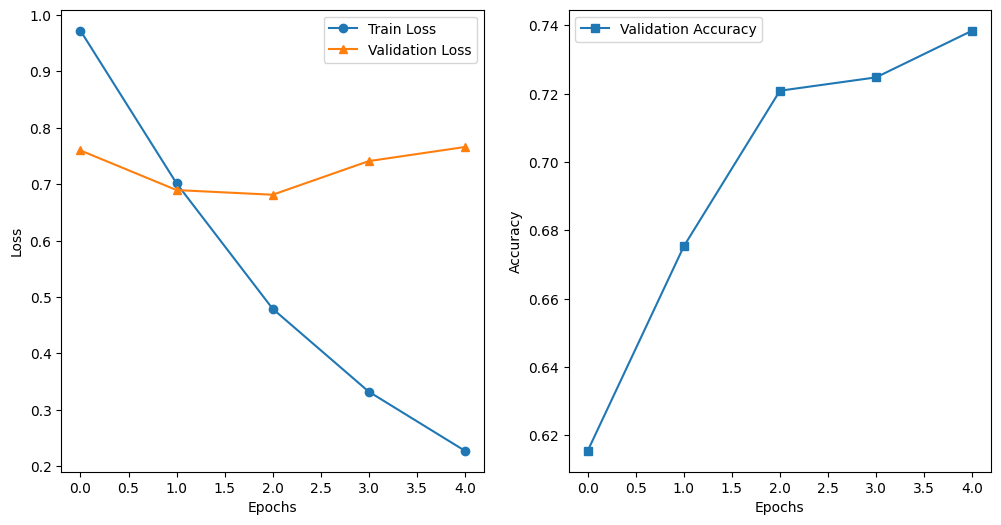

In [21]:
plot_loss_accuracy_changes(train_loss_list, val_loss_list, accuracy_list)